Plate Reconstruction and Conversion to World Builder JSON
----------------------------------------------------------
This script reconstructs tectonic plates at a specified geological time using either remote 
plate model data or local files. It extracts key geological features such as continents, 
ridges, and trenches, and saves them in GeoJSON format. Additionally, it converts these 
GeoJSON files into World Builder-compatible JSON files to facilitate further geodynamic 
modeling and visualization.

**Workflow:**
1. The script loads plate reconstruction data (from remote repository or local files).
2. It extracts and saves key geological features as GeoJSON files.
3. The extracted GeoJSON files are then converted into World Builder-compatible JSON.
4. A final JSON output is saved with all processed features directly usable by GWB.

**Usage Instructions:**
- Configure `reconstruction_time` to set the geological age.
- Set `use_local_files` to `True` to use local data, otherwise, it will fetch from the remote repository.
- Ensure required dependencies are installed: `pygplates`, `gplately`, `matplotlib`, `cartopy`.

**Outputs:**
- GeoJSON files for each feature type (e.g., continents, ridges, trenches).
- A final World Builder JSON file saved in `contrib/gplate/data/`.

Feature 'continents' saved as ./data/continents.geojson
Feature 'ridges_and_transforms' saved as ./data/ridges_and_transforms.geojson
Feature 'trenches' saved as ./data/trenches.geojson
Age grid not available for this model.
Plate reconstruction plot saved as ./data/Merdith2021_400Ma_reconstruction.png


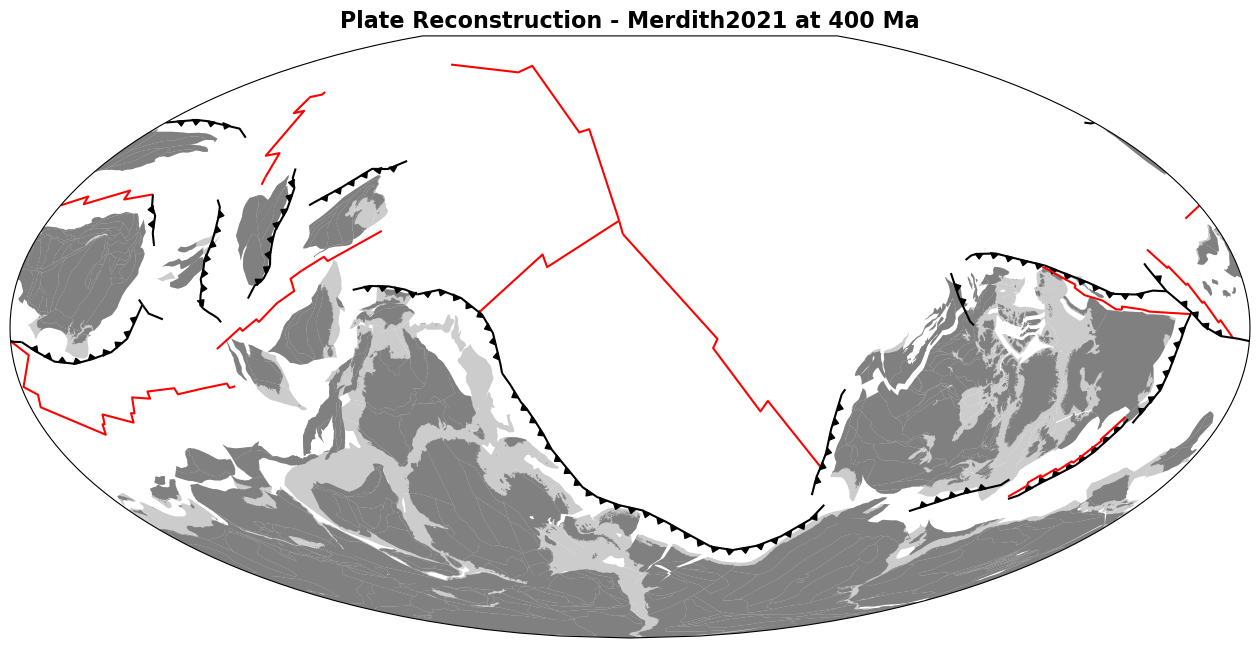

In [9]:
import sys
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pygplates
import json

# Set path if necessary
# sys.path.append('/Users/ponsm/pygplates_0.36.0_py310_Darwin-arm64')  # Update path if different

import gplately
from plate_model_manager import PlateModelManager

# User-defined parameters
reconstruction_time = 400  # Ma
plate_reconstruction_model = "Merdith2021" #Muller2019
use_local_files = False  # Set to True to use local files instead of online repo

#for use of local files use 
input_directory = "./path/to/local_plate_reconstruction/"


# Define the output directory
output_dir = "./data/"
os.makedirs(output_dir, exist_ok=True)

# Load plate model data based on user choice
if use_local_files:

    ## Example of use of local file in https://gplates.github.io/gplately/v1.3.0/02-PlateReconstructions.html
    ## Using data set :
    ## https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_PlateMotionModel/

    ## Use the following files
    # coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp"
    # continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
    # COBs = input_directory+"StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_IsoCOB_2019_v2.gpml"
    # input_directory = "./local_repository_where_downloaded/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"
    # static_polygon_file = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
        
    # Load rotation model
    rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
    rotation_model = pygplates.RotationModel(rotation_filenames)

    # Load topology features
    topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
    topology_features = pygplates.FeatureCollection()
    for topology_filename in topology_filenames:
        if "Inactive" not in topology_filename:
            topology_features.add(pygplates.FeatureCollection(topology_filename))

    # Load static polygons
    
    static_polygon_file = os.path.join(input_directory, "StaticGeometries/StaticPolygons/polygons.shp")
    static_polygons = pygplates.FeatureCollection(static_polygon_file)

else:
    # Load model data from remote repository
    pm_manager = PlateModelManager()
    model_data = pm_manager.get_model(plate_reconstruction_model, data_dir="plate-model-repo")
    rotation_model = model_data.get_rotation_model()
    topology_features = model_data.get_topologies()
    static_polygons = model_data.get_static_polygons()

    # Load coastline and continent data
    coastlines = model_data.get_layer('Coastlines')
    continents = model_data.get_layer('ContinentalPolygons')

# Create plate reconstruction model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Initialize PlotTopologies with the plate reconstruction model and data layers
gplot = gplately.PlotTopologies(model, coastlines=coastlines, continents=continents)

# Set reconstruction time
gplot.time = reconstruction_time  # Ma

# Define the default features to extract
default_features = {
    "continents": gplot.get_continents,
    "ridges_and_transforms": gplot.get_ridges_and_transforms,
    "trenches": gplot.get_trenches
}

# Extract and save the default features
for feature, func in default_features.items():
    try:
        geo_data = func()
        if geo_data is None or geo_data.empty:
            print(f"Feature '{feature}' is not available for this plate reconstruction model.")
        else:
            file_path = os.path.join(output_dir, f"{feature}.geojson")
            geo_data.to_file(file_path, driver="GeoJSON")
            print(f"Feature '{feature}' saved as {file_path}")
    except Exception as e:
        print(f"Error extracting '{feature}': {e}")

# Plot the data
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')

# Simulate an age grid (replace with actual data if available)
try:
    agegrid = model.get_age_grid()
    im = gplot.plot_grid(ax1, agegrid.data, cmap='YlGnBu', vmin=0, vmax=200)
    fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')
except AttributeError:
    print("Age grid not available for this model.")

# Add title with time and model information
title_text = f"Plate Reconstruction - {plate_reconstruction_model} at {reconstruction_time} Ma"
ax1.set_title(title_text, fontsize=16, fontweight='bold')

# Save the plot
plot_file_path = os.path.join(output_dir, f"{plate_reconstruction_model}_{reconstruction_time}Ma_reconstruction.png")
plt.savefig(plot_file_path, dpi=300, bbox_inches='tight')
print(f"Plate reconstruction plot saved as {plot_file_path}")

# Show the plot (optional)
plt.show()


## GeoJSON to World Builder JSON Conversion

This script converts GeoJSON files containing geological features into a World Builder-compatible JSON format for geodynamic modeling, assigning appropriate properties such as depth, thermal, and compositional characteristics. 

Plate boundaries, such as ridges and trenches, are converted into **Fault** features, which include properties like dip angle, segment length, and composition variations. Continents are represented as **Continental Plate** features, characterized by uniform composition and a defined maximum depth.

In [5]:
def convert_geojson_to_worldbuilder_json(geojson_file, default_max_depth=350e3):
    """
    Converts a GeoJSON file to a JSON dictionary formatted for use in World Builder.
    
    Args:
        geojson_file (str): Path to the input GeoJSON file.
        default_max_depth (float): Default maximum depth for all plates.
    
    Returns:
        list: Converted JSON features formatted for World Builder.
    """
    try:
        with open(geojson_file, 'r') as f:
            geojson_data = json.load(f)

        features = []
        continental_counter = 1
        fault_counter = 1
        trench_counter = 1

        for feature in geojson_data.get('features', []):
            geometry_type = feature.get('geometry', {}).get('type')
            coordinates = feature.get('geometry', {}).get('coordinates', [])

            if geometry_type == "Polygon":
                # Handle continent polygon correctly
                processed_coords = coordinates[0]  # Outer ring

                feature_data = {
                    "model": "continental plate",
                    "name": f'continental_plate_{continental_counter}',
                    "max depth": default_max_depth,
                    "coordinates": processed_coords,
                    "temperature models": [{"model": "linear", "max depth": default_max_depth}],
                    "composition models": [
                        {
                            "model": "uniform",
                            "compositions": [0],
                            "max depth": default_max_depth
                        }
                    ]
                }
                features.append(feature_data)
                continental_counter += 1

            elif geometry_type == "LineString":
                # Handle ridges and trenches differently based on filename
                feature_name = os.path.basename(geojson_file).lower()
                composition_number = 2 if "trench" in feature_name else 1

                feature_data = {
                    "model": "fault",
                    "name": f'{"trench" if "trench" in feature_name else "fault"}_{fault_counter}',
                    "coordinates": coordinates,
                    "dip point": [0, 1],
                    "min depth": -1000.0,
                    "max depth": 300000.0,
                    "segments": [{"length": 300000.0, "thickness": [100000.0], "angle": [90, 90]}],
                    "composition models": [{"model": "smooth", "compositions": [composition_number], "side distance fault center": 50000.0}]
                }
                features.append(feature_data)
                fault_counter += 1

            elif geometry_type == "MultiLineString":
                for segment in coordinates:
                    feature_name = os.path.basename(geojson_file).lower()
                    composition_number = 2 if "trench" in feature_name else 1

                    feature_data = {
                        "model": "fault",
                        "name": f'{"trench" if "trench" in feature_name else "fault"}_{trench_counter}',
                        "coordinates": segment,
                        "dip point": [0, 1],
                        "min depth": -1000.0,
                        "max depth": 300000.0,
                        "segments": [{"length": 300000.0, "thickness": [100000.0], "angle": [90, 90]}],
                        "composition models": [{"model": "smooth", "compositions": [composition_number], "side distance fault center": 50000.0}]
                    }
                    features.append(feature_data)
                    trench_counter += 1

        return features

    except Exception as e:
        print(f"Error processing {geojson_file}: {e}")
        return None

# Define input and output directories
data_dir = "contrib/gplate/data/"
output_file = os.path.join(data_dir, "world_builder_model.json")

# Process GeoJSON files
geojson_files = [f for f in os.listdir(data_dir) if f.endswith('.geojson')]
all_features = []

for geojson_file in geojson_files:
    file_path = os.path.join(data_dir, geojson_file)
    features = convert_geojson_to_worldbuilder_json(file_path)
    if features:
        all_features.extend(features)

# Combine all features into a World Builder JSON structure
output_data = {
    "version": "1.1",
    "interpolation": "continuous monotone spline",
    "coordinate system": {
        "model": "spherical",
        "depth method": "starting point"
    },
    "features": all_features
}

# Save combined JSON in the same data directory
with open(output_file, 'w') as out_f:
    json.dump(output_data, out_f, indent=4)

print(f"Conversion successful! Output saved to {output_file}")


Conversion successful! Output saved to contrib/gplate/data/world_builder_model.json
